<a href="https://colab.research.google.com/github/garylau1/model_training/blob/main/transfer_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is our classification task in the animals.
We get very high accuracy after using transfer learning.(around98%)


In [ ]:
# Check for GPU
!nvidia-smi

Tue Jul 16 16:32:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

2.3.0+cu121


## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [ ]:
# 1. Get data
from pathlib import Path
import requests
import zipfile

image_path=Path("data_set")
#image_path.mkdir(parents=True,exist_ok=True)


#with open (image_path/"cell.zip","wb") as f :
  #request=requests.get("data")
  #f.write(request.content)

#with zipfile.ZipFile(image_path/"cell.zip","r") as zip_ref:
  #zip_ref.extractall(image_path)

In [ ]:
!git clone https://github.com/kavishsanghvi/fauna-image-classification-using-convolutional-neural-network.git

Cloning into 'fauna-image-classification-using-convolutional-neural-network'...
remote: Enumerating objects: 17032, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 17032 (delta 13), reused 11 (delta 3), pack-reused 17002
Receiving objects: 100% (17032/17032), 329.97 MiB | 14.53 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (17820/17820), done.


In [ ]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
# Setup train and testing paths
train_paths=Path("/content/fauna-image-classification-using-convolutional-neural-network/data/train")
test_paths=Path("/content/fauna-image-classification-using-convolutional-neural-network/data/test")
val_paths=Path("/content/fauna-image-classification-using-convolutional-neural-network/data/validation")
whole_paths=Path("/content/fauna-image-classification-using-convolutional-neural-network/data/")
walk_through_dir(test_paths)

There are 6 directories and 8 images in '/content/fauna-image-classification-using-convolutional-neural-network/data/test'.
There are 0 directories and 371 images in '/content/fauna-image-classification-using-convolutional-neural-network/data/test/butterflies'.
There are 0 directories and 403 images in '/content/fauna-image-classification-using-convolutional-neural-network/data/test/spiders'.
There are 0 directories and 203 images in '/content/fauna-image-classification-using-convolutional-neural-network/data/test/chickens'.
There are 0 directories and 152 images in '/content/fauna-image-classification-using-convolutional-neural-network/data/test/elephants'.
There are 0 directories and 244 images in '/content/fauna-image-classification-using-convolutional-neural-network/data/test/squirells'.
There are 0 directories and 472 images in '/content/fauna-image-classification-using-convolutional-neural-network/data/test/horses'.


In [ ]:
train_paths
whole_paths=Path("/content/fauna-image-classification-using-convolutional-neural-network/data/")
list_path=list(whole_paths.glob("*/*/*.jpeg"))


225 300


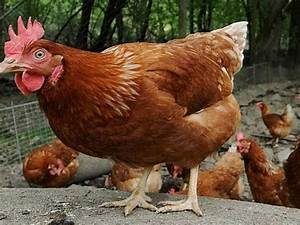

In [ ]:
# Do the image visualization with matplotlib

import random
from PIL import Image

radom_path=random.choice(list_path)
radom_path.parent.stem

img=Image.open(radom_path)



print(img.height,img.width)

img

In [ ]:
#

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [ ]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [ ]:
import torch

import torchvision



device= "cuda" if torch.cuda.is_available() else "cpu"


weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_0=torchvision.models.efficientnet_b2(weights=weights).to(device)

for param in model_0.features.parameters():
    param.requires_grad = False

model_0.classifier=torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=6, # same number of output units as our number of classes
                    bias=True)).to(device)

data_transform=weights.transforms()


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 140MB/s]


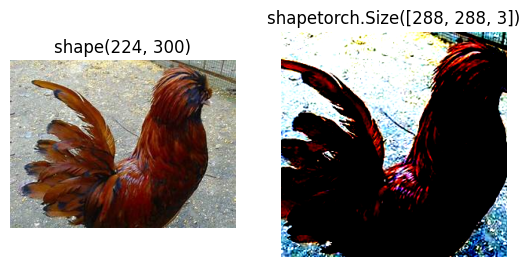

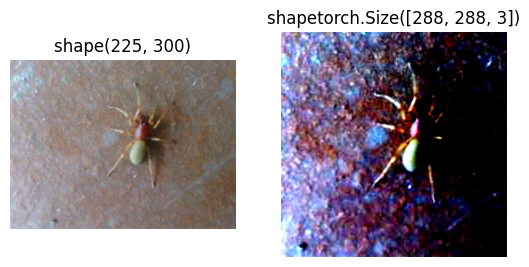

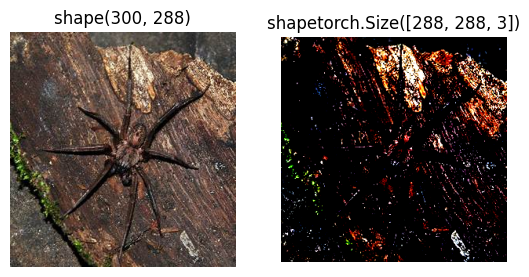

In [ ]:
# Write a function to plot transformed images
import matplotlib.pyplot as plt


def plot_image(image_path_list,transform,n=3):
  random_path=random.sample(image_path_list,k=3)

  for i in random_path:
    fig,ax=plt.subplots(1,2)
    img=Image.open(i)
    ax[0].imshow(img)

    transform_img=transform(img)
    ax[0].set_title(f"shape{img.height,img.width}")
    ax[0].axis("off")
    ax[1].imshow(transform_img.permute(1,2,0))
    ax[1].set_title(f"shape{transform_img.permute(1,2,0).shape}")
    ax[1].axis("off")



plot_image(list_path,data_transform,n=3)




In [ ]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
import os

for i in list(os.listdir("/content/fauna-image-classification-using-convolutional-neural-network/data/test")):
  if (i[-1:-4:-1])=="gpj" or (i[-1:-5:-1])=="gepj" :
      os.remove("/content/fauna-image-classification-using-convolutional-neural-network/data/test/"+i)

classes=sorted([i.name for i in list (os.scandir(test_paths))])

{ classes[i]: i for i in range(len(classes))}


{'butterflies': 0,
 'chickens': 1,
 'elephants': 2,
 'horses': 3,
 'spiders': 4,
 'squirells': 5}

In [ ]:
if not None:
  print (classes)

['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']


In [ ]:

classes=sorted([i.name for i in list (os.scandir(train_paths))])

{ classes[i]: i for i in range(len(classes))}

{'butterflies': 0,
 'chickens': 1,
 'elephants': 2,
 'horses': 3,
 'spiders': 4,
 'squirells': 5}

### Load image data using `ImageFolder`

In [ ]:
train_paths=Path("/content/fauna-image-classification-using-convolutional-neural-network/data/train")

# Use ImageFolder to create dataset(s)

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets,transforms
import random
from PIL import Image


class customdata(Dataset):
  def __init__(self,paths,transform=None):
    self.list_file=sorted(list(paths.glob("*/*.jpeg")))
    self.transform=transform
    self.paths=paths

    self.class_toidx=self.class_to_idx()

  def __len__(self):
    return len(list(self.list_file))

  def print_image(self,index):
    img=Image.open(self.list_file[index])

    return img

  def class_to_idx(self):
    classes=sorted([i.name for i in list (os.scandir(self.paths))])

    return { classes[i]: i for i in range(len(classes))}


  def __getitem__(self,index):
    image1=self.print_image(index)

    indexes=self.class_to_idx()

    name_withindex=self.list_file[index].parent.stem




    index1=indexes[name_withindex]

    if self.transform:
      return (self.transform(image1),index1)
    else:
      return image1,index1



# Can also get class names as a dict



train_data=customdata(train_paths,data_transform)
test_data=customdata(test_paths,data_transform)
val_data=customdata(val_paths,data_transform)

class_dict = test_data.class_toidx
class_dict


{'butterflies': 0,
 'chickens': 1,
 'elephants': 2,
 'horses': 3,
 'spiders': 4,
 'squirells': 5}

In [ ]:
# Check the lengths of each dataset
len(train_data), len(test_data),len(val_data)

(12161, 1845, 2549)

In [ ]:
def class_to_idx(path):
    classes=sorted([i.name for i in list (os.scandir(path))])

    return { classes[i]: i for i in range(len(classes))}

class_to_idx(train_paths)

{'butterflies': 0,
 'chickens': 1,
 'elephants': 2,
 'horses': 3,
 'spiders': 4,
 'squirells': 5}

In [ ]:
train_val_sets = torch.utils.data.ConcatDataset([train_data, val_data])
len(train_val_sets)

14710

In [ ]:
test_data[1672]

(tensor([[[-0.3198, -0.3027, -0.2856,  ..., -2.1179, -2.1179, -1.2788],
          [-0.3712, -0.3541, -0.3198,  ..., -2.0837, -0.8678, -0.5424],
          [-0.4568, -0.4397, -0.4226,  ..., -1.7412,  0.7077, -0.0287],
          ...,
          [ 0.0741,  0.0741,  0.0741,  ...,  1.0331,  0.9988,  0.9988],
          [ 0.0912,  0.0912,  0.0912,  ...,  1.0331,  0.9817,  0.9988],
          [ 0.1083,  0.1083,  0.1083,  ...,  1.0331,  0.9988,  0.9988]],
 
         [[ 0.2402,  0.2577,  0.2752,  ..., -1.8256, -1.8081, -0.8627],
          [ 0.1877,  0.2052,  0.2402,  ..., -1.7206, -0.4426, -0.0924],
          [ 0.1001,  0.1176,  0.1527,  ..., -1.3529,  1.1681,  0.4328],
          ...,
          [ 0.8004,  0.8004,  0.8004,  ...,  1.4132,  1.4132,  1.3957],
          [ 0.8179,  0.8179,  0.8179,  ...,  1.4482,  1.4482,  1.4307],
          [ 0.8529,  0.8529,  0.8354,  ...,  1.4657,  1.4657,  1.4482]],
 
         [[-0.7064, -0.6715, -0.6367,  ..., -1.7696, -1.7696, -0.9156],
          [-0.7587, -0.7064,

In [ ]:
# Turn train and test Datasets into DataLoaders

from torch.utils.data import DataLoader

train_loader=DataLoader(train_val_sets,32,True,num_workers=os.cpu_count())
test_loader=DataLoader(test_data,32,False,num_workers=os.cpu_count())



In [ ]:
# How many batches of images are in our data loaders?
len(train_loader),len(test_loader)



(460, 58)

In [ ]:
test_one=next(iter(train_loader))[0]
test_one=test_one.to(device)

test_one.shape

torch.Size([32, 3, 288, 288])

In [ ]:
from torch import nn

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [ ]:
try:
  import torchinfo
except:
  ! pip install torchinfo
  import torchinfo

from torchinfo import summary


summary(model_0,input_size=[1,3,200,200])

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 6]                    --
├─Sequential: 1-1                                       [1, 1408, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 100, 100]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 100, 100]         (864)
│    │    └─BatchNorm2d: 3-2                            [1, 32, 100, 100]         (64)
│    │    └─SiLU: 3-3                                   [1, 32, 100, 100]         --
│    └─Sequential: 2-2                                  [1, 16, 100, 100]         --
│    │    └─MBConv: 3-4                                 [1, 16, 100, 100]         (1,448)
│    │    └─MBConv: 3-5                                 [1, 16, 100, 100]         (612)
│    └─Sequential: 2-3                                  [1, 24, 50, 50]           --
│    │    └─MBConv: 3-6                        

## 4. Create training and testing functions for `model_0`.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,device=device):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for X,y in dataloader:
    # Send data to target device
    X=X.to(device)
    y=y.to(device)
    # 1. Forward pass
    y_logit=model(X)

    y_pred=torch.softmax(y_logit,-1).argmax(-1)
    # 2. Calculate and accumulate loss
    loss=loss_fn(y_logit,y)  #average lost for one batch
    train_loss=train_loss+loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    train_acc=train_acc+torch.sum(y_pred==y).item()/len(y)

  # Adjust metrics to get average loss and average accuracy per batch
  train_acc=train_acc/len(dataloader)
  train_loss=train_loss/len(dataloader)

  return (train_loss,train_acc)

In [ ]:
import os


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,device=device):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():

    # Loop through DataLoader batches
    for X,y in dataloader:
    # Send data to target device
      X=X.to(device)
      y=y.to(device)
    # 1. Forward pass
      y_logit=model(X)

      y_pred=torch.softmax(y_logit,-1).argmax(-1)



      # 2. Calculuate and accumulate loss
      loss=loss_fn(y_logit,y)  #average lost for one batch
      test_loss=test_loss+loss

      test_acc=test_acc+torch.sum(y_pred==y).item()/len(y)

  # Adjust metrics to get average loss and average accuracy per batch
  test_acc=test_acc/len(dataloader)
  test_loss=test_loss/len(dataloader)

  return (test_loss,test_acc)

      # Calculate and accumulate accuracy


  # Adjust metrics to get average loss and accuracy per batch


In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)



## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [ ]:
# Train for 5 epochs
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

train(model_0,train_loader,test_loader,optimizer,loss_fn)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2437 | train_acc: 0.9404 | test_loss: 0.0915 | test_acc: 0.9792
Epoch: 2 | train_loss: 0.1194 | train_acc: 0.9631 | test_loss: 0.0782 | test_acc: 0.9801
Epoch: 3 | train_loss: 0.0989 | train_acc: 0.9696 | test_loss: 0.0676 | test_acc: 0.9806
Epoch: 4 | train_loss: 0.0966 | train_acc: 0.9697 | test_loss: 0.0672 | test_acc: 0.9795
Epoch: 5 | train_loss: 0.0898 | train_acc: 0.9725 | test_loss: 0.0627 | test_acc: 0.9822


{'train_loss': [tensor(0.2437, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1194, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0989, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0966, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0898, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [0.9403903162055336,
  0.963086709486166,
  0.969633152173913,
  0.9697010869565217,
  0.9724555335968379],
 'test_loss': [tensor(0.0915, device='cuda:0'),
  tensor(0.0782, device='cuda:0'),
  tensor(0.0676, device='cuda:0'),
  tensor(0.0672, device='cuda:0'),
  tensor(0.0627, device='cuda:0')],
 'test_acc': [0.9792436371100164,
  0.9800646551724138,
  0.9806034482758621,
  0.9795258620689655,
  0.9822198275862069]}

In [ ]:


train(model_0,train_loader,test_loader,optimizer,loss_fn,epochs=30)

In [ ]:
train(model_0,train_loader,test_loader,optimizer,loss_fn,epochs=30)

In [ ]:
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.0005)

train(model_0,train_loader,test_loader,optimizer,loss_fn,epochs=50)

In [ ]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO,
                             lr=0.001)

In [ ]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO,
                             lr=0.001)

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torch.utils.data import Dataset
import random
from PIL import Image
from pathlib import Path
import requests
import zipfile

class customdata(Dataset):
  def __init__(self,paths,transform=None):
    self.list_file=sorted(list(paths.glob("*/*.jpg")))
    self.transform=transform
    self.paths=paths

    self.class_toidx=self.class_to_idx()

  def __len__(self):
    return len(list(self.list_file))

  def print_image(self,index):
    img=Image.open(self.list_file[index])

    return img

  def class_to_idx(self):
    classes=sorted([i.name for i in list (os.scandir(self.paths))])

    return { classes[i]: i for i in range(len(classes))}


  def __getitem__(self,index):
    image1=self.print_image(index)

    indexes=self.class_to_idx()

    name_withindex=self.list_file[index].parent.stem




    index1=indexes[name_withindex]

    if self.transform:
      return (self.transform(image1),index1)
    else:
      return image1,index1


In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import torch
from torch import nn
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

In [ ]:
# See how many images we have
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

Excellent, we now have double the training and testing images...

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_dataset=customdata(train_data_20_percent_path,simple_transform)

test_dataset=customdata(test_data_20_percent_path,simple_transform)

(train_dataset).class_toidx

(train_dataset)[123][0].shape

# Create dataloaders


In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class_len=len((train_dataset).class_toidx)
class_len

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [ ]:
train_loader=DataLoader(train_dataset,32,True,num_workers=os.cpu_count())
test_loader=DataLoader(test_dataset,32,False,num_workers=os.cpu_count())

In [ ]:
test_one=next(iter(test_loader))[0]

In [ ]:
class vggmodel(nn.Module):
  def __init__(self,in_feature,hidden1,hidden2,hidden3,hidden4,out_feature):
    super().__init__()
    self.block_1=nn.Sequential(nn.Conv2d(in_feature,hidden1,kernel_size=3),nn.ReLU(),nn.Conv2d(hidden1,hidden2,kernel_size=3),nn.ReLU(),nn.MaxPool2d(2))
    self.block_2=nn.Sequential(nn.Conv2d(hidden2,hidden3,kernel_size=3),nn.ReLU(),nn.Conv2d(hidden3,hidden4,kernel_size=3),nn.ReLU(),nn.MaxPool2d(2))
    #self.block_3=nn.Sequential(nn.Conv2d(hidden4,hidden5,kernel_size=3),nn.ReLU(),nn.Conv2d(hidden5,hidden6,kernel_size=3),nn.ReLU(),nn.MaxPool2d(2))

    self.last=nn.Sequential(nn.Flatten(),nn.Linear(1521,out_feature))

  def forward(self,x):
    return self.last((self.block_2(self.block_1(x))))


device = "cuda" if torch.cuda.is_available() else "cpu"
device



model_0=vggmodel(3,18,18,9,9,class_len)
model_0=model_0.to(device)
model_0(test_one)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,device=device):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for X,y in dataloader:
    # Send data to target device
    X=X.to(device)
    y=y.to(device)
    # 1. Forward pass
    y_logit=model(X)

    y_pred=torch.softmax(y_logit,-1).argmax(-1)
    # 2. Calculate and accumulate loss
    loss=loss_fn(y_logit,y)  #average lost for one batch
    train_loss=train_loss+loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    train_acc=train_acc+torch.sum(y_pred==y).item()/len(y)

  # Adjust metrics to get average loss and average accuracy per batch
  train_acc=train_acc/len(dataloader)
  train_loss=train_loss/len(dataloader)

  return (train_loss,train_acc)


import os


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,device=device):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():

    # Loop through DataLoader batches
    for X,y in dataloader:
    # Send data to target device
      X=X.to(device)
      y=y.to(device)
    # 1. Forward pass
      y_logit=model(X)

      y_pred=torch.softmax(y_logit,-1).argmax(-1)



      # 2. Calculuate and accumulate loss
      loss=loss_fn(y_logit,y)  #average lost for one batch
      test_loss=test_loss+loss

      test_acc=test_acc+torch.sum(y_pred==y).item()/len(y)

  # Adjust metrics to get average loss and average accuracy per batch
  test_acc=test_acc/len(dataloader)
  test_loss=test_loss/len(dataloader)

  return (test_loss,test_acc)

      # Calculate and accumulate accuracy


  # Adjust metrics to get average loss and accuracy per batch
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)



In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

train(model_0,train_loader,test_loader,optimizer,loss_fn,20)

In [ ]:
custom_image="new_image"

with open("pizza_image.jpg1", "wb") as f:
    request=requests.get("https://img.freepik.com/premium-photo/fresh-tasty-pizza-with-pepperoni-isolated-white_136401-2336.jpg")
    f.write(request.content)

import torchvision
img = torchvision.io.read_image("pizza_image.jpg1")
img

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in HWC (height, width, color_channels) format not CHW (color_channels, height, width)
plt.axis(False);

In [ ]:
#!wget "https://www.foodandwine.com/thmb/4qg95tjf0mgdHqez5OLLYc0PNT4=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/classic-cheese-pizza-FT-RECIPE0422-31a2c938fc2546c9a07b7011658cfd05.jpg"

#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg


#img = mpimg.imread("/content/classic-cheese-pizza-FT-RECIPE0422-31a2c938fc2546c9a07b7011658cfd05.jpg")
#plt.imshow(img)
#plt.axis('off')
#plt.show()

img.shape

In [ ]:
model_0.eval()

with torch.inference_mode():
  img=img/255
  img=transforms.Resize((64,64))(img)

  img=img.unsqueeze(0)


  logit=model_0(img)

In [ ]:
logit

In [ ]:
plt.imshow(img.squeeze().permute(1, 2, 0))